In [1]:
# !pip install segmentation-models-pytorch
# !pip install ipywidgets

## Import

In [2]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

## Root

In [3]:
ROOT_PATH = '/home/yasaisen/Desktop/13_research/research_main/lab_03'
DATA_PATH = '/home/yasaisen/Desktop/13_research/research_main/lab_00'

Setup config class

In [4]:
class Config:
    
    data_dir = os.path.join(DATA_PATH, "kaggle_3m/")
    
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32
    
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1
    
    seed = 1
    learning_rate = 0.01
    epochs = 30
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Helper Functions

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def plot_example(idx):
    base_path = Config.data_dir+ test_df['directory'].iloc[idx]
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[1].imshow(mask)
    ax[1].set_title("Mask")
    plt.show()

In [6]:
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap="gray")
    if title:
        fig.suptitle(title)
    plt.show()

In [7]:
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device)
    
    model.eval()
    
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1,2,0)).squeeze()
        rounded = np.round(pred)
        
    plot_images = {
        'Image': img,
        'Mask': mask,
        'Predicted Mask': pred,
        'Predicted Rounded Mask':rounded
    }
    
    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
        
    plt.show()
        
        

In [8]:
set_seed(Config.seed)

Preparing Data

In [9]:
dirs, images, masks = [], [], []

i =0

for root, folders, files in  os.walk(Config.data_dir):
    for file in files:
        if 'mask' in file:
            dirs.append(root.replace(Config.data_dir, ''))
            masks.append(file)
            images.append(file.replace("_mask", ""))

PathDF = pd.DataFrame({'directory': dirs,
                      'images': images,
                      'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_16.tif,TCGA_HT_7690_19960312_16_mask.tif
1,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_10.tif,TCGA_HT_7690_19960312_10_mask.tif
2,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_18.tif,TCGA_HT_7690_19960312_18_mask.tif
3,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_17.tif,TCGA_HT_7690_19960312_17_mask.tif
4,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_9.tif,TCGA_HT_7690_19960312_9_mask.tif


In [10]:
for i in PathDF.index:
    PathDF.loc[i, "diagnosis"] = 1 if np.max(cv2.imread(os.path.join(Config.data_dir, PathDF.loc[i, 'directory'], PathDF.loc[i,"masks"]))) > 0 else 0

In [11]:
PathDF.head()

,directory,images,masks,diagnosis
0,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_16.tif,TCGA_HT_7690_19960312_16_mask.tif,1.0
1,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_10.tif,TCGA_HT_7690_19960312_10_mask.tif,0.0
2,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_18.tif,TCGA_HT_7690_19960312_18_mask.tif,1.0
3,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_17.tif,TCGA_HT_7690_19960312_17_mask.tif,1.0
4,TCGA_HT_7690_19960312,TCGA_HT_7690_19960312_9.tif,TCGA_HT_7690_19960312_9_mask.tif,0.0


In [12]:
PathDF['diagnosis'].value_counts()

0.0    2556
1.0    1373
Name: diagnosis, dtype: int64

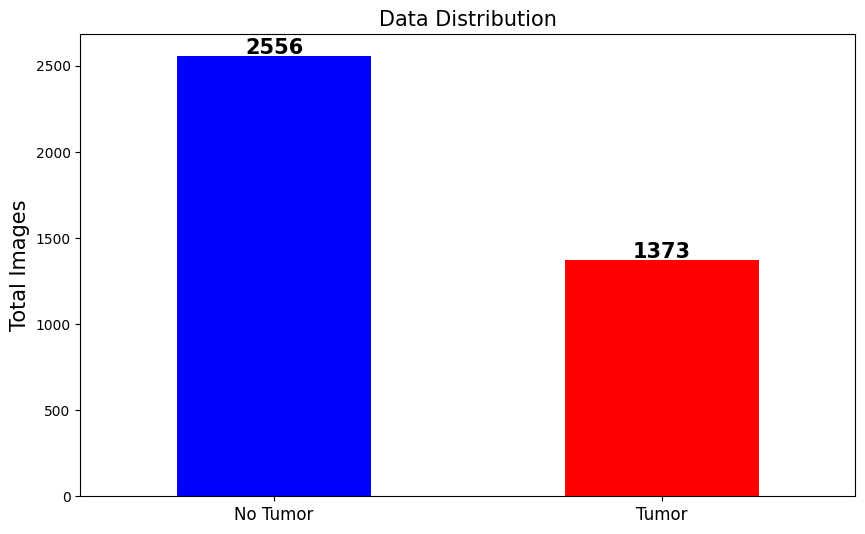

In [13]:
ax = PathDF['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(PathDF['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

Train, Val, Test Split

In [14]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction / train2rest

train_df, rest = train_test_split(PathDF, random_state=Config.seed,
                                 test_size = train2rest)

test_df, valid_df = train_test_split(rest, random_state=Config.seed,
                                    test_size = test2valid)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 2946
Valid: 590
Test: 393


Visualization of images and masks

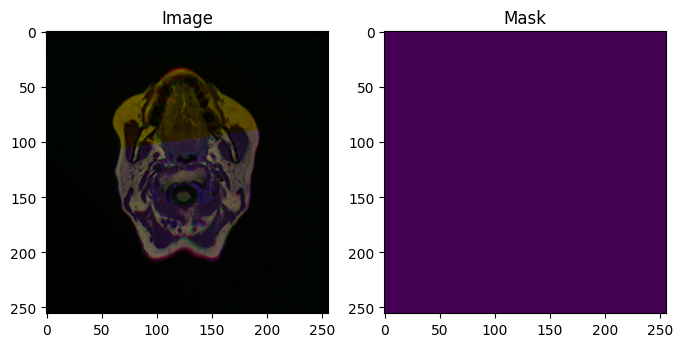

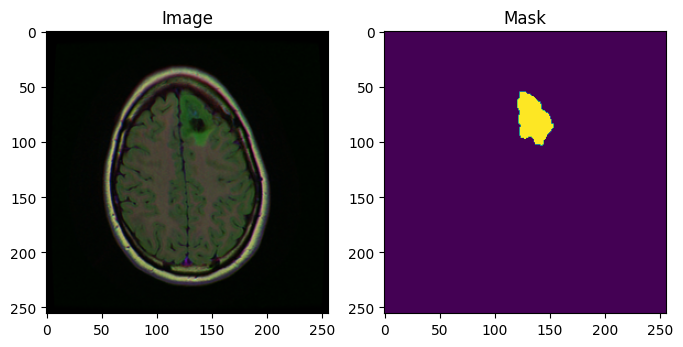

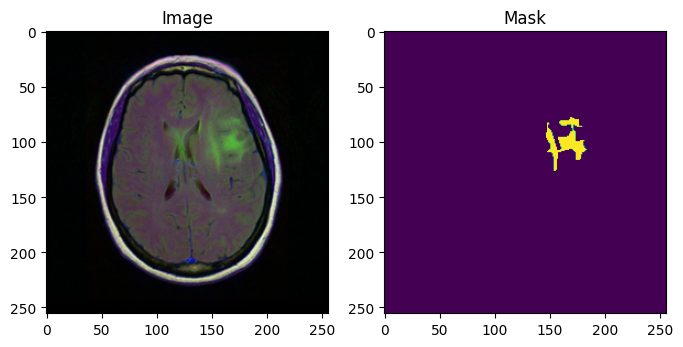

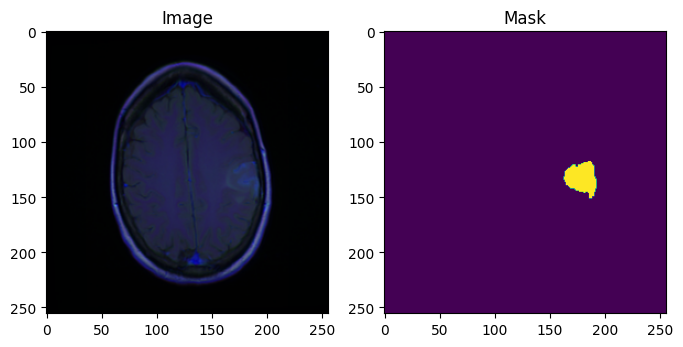

In [15]:
plot_example(0)
plot_example(5)
plot_example(10)
plot_example(20)

Dataset Class

In [16]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform
        
    def __len__(self):
        return self.path_df.shape[0]
    
    def __getitem__(self, idx):
        
        base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        sample = (image, mask)
        
        if self.transform:
            sample = self.transform(sample)

        image, mask = sample
        # print(type(image), np.asarray(image).shape, type(mask), np.asarray(mask).shape)
            
        return sample

Custom Transformations

In [17]:
class PairedRandomHorizontalFlip():
    def __init__(self, p=0.5):
        self.p = p
        
    def __call__(self, sample):
        img, mask = sample
        if np.random.random() < self.p:
            img, mask = TF.hflip(img), TF.hflip(mask)
            
        return img, mask

In [18]:
class PairedRandomAffine():
    def __init__(self, degrees= None, translate=None, scale_ranges=None,
                shears=None):
        self.params = {
            'degree': degrees,
            'translate': translate,
            'scale_ranges':scale_ranges,
            'shears':shears
        }
    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        
        angle, translations, scale, shear = transforms.RandomAffine.get_params(
            self.params['degree'], self.params['translate'],
            self.params['scale_ranges'], self.params['shears'],
            (w,h)
        )
        
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        
        return img, mask

In [19]:
class PairedToTensor():
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask

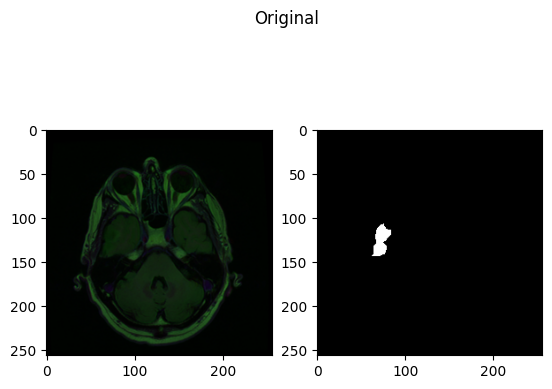

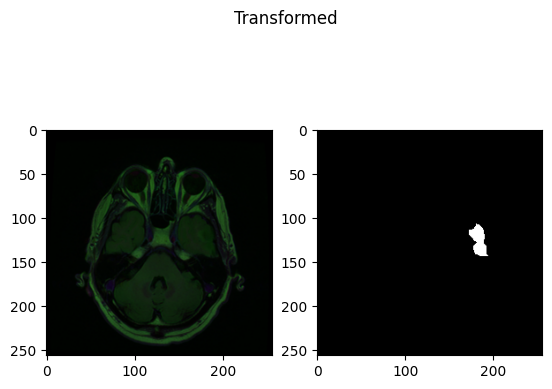

In [20]:
dataset = MRI_Dataset(test_df)
sample = dataset[59]
transform = PairedRandomHorizontalFlip(p=1)
show_sample(sample, title='Original')
show_sample(transform(sample), title="Transformed")

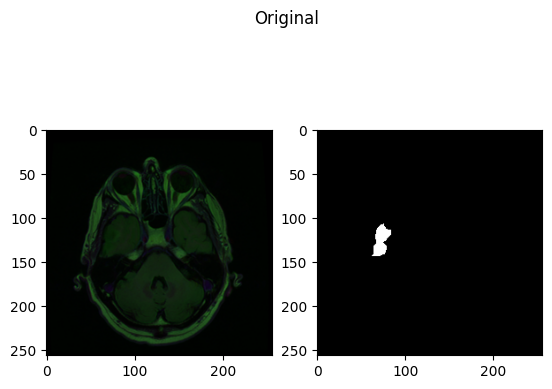

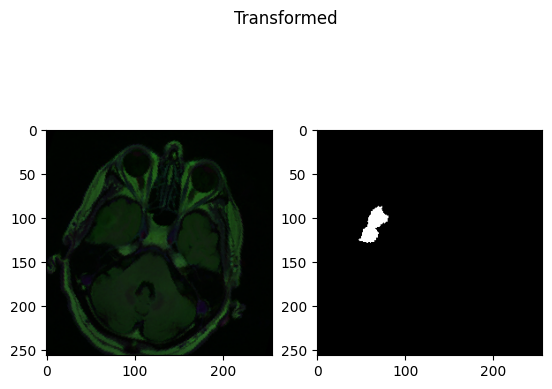

In [21]:
transform = PairedRandomAffine(
    degrees = (15,15),
    scale_ranges = (1.2, 1.2)
)
show_sample(sample, "Original")
show_sample(transform(sample), 'Transformed')

Data transformations and loaders

In [22]:
train_transforms = transforms.Compose(
    [PairedRandomHorizontalFlip(),
    PairedRandomAffine(
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    PairedToTensor()
    ])

eval_transforms = PairedToTensor()

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=eval_transforms)
test_data = MRI_Dataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_data, batch_size=Config.train_batch,
                         shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch,
                         shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=Config.test_batch,
                        shuffle=False, num_workers=2)

Defining the Model

In [23]:
class Block(nn.Module): 
	def __init__(self, input_ch, output_ch): 
		super().__init__() 
		self.conv1 = nn.Conv2d(input_ch, output_ch, 3) 
		self.relu = nn.ReLU() 
		self.conv2 = nn.Conv2d(output_ch, output_ch, 3) 
 
	def forward(self, x): 
		output = self.conv1(x)
		output = self.relu(output)
		output = self.conv2(output)
		return output

In [24]:
class Encoder(nn.Module): 
	def __init__(self, channels=(3, 16, 32, 64)): 
		super().__init__() 
		self.encBlocks = nn.ModuleList( 
			[Block(channels[i], channels[i + 1]) 
			 	for i in range(len(channels) - 1)]) 
		self.pool = nn.MaxPool2d(2) 
 
	def forward(self, x): 
		blockOutputs = [] 
 
		for block in self.encBlocks: 
			x = block(x) 
			blockOutputs.append(x) 
			x = self.pool(x) 
 
		return blockOutputs

In [25]:
class Decoder(nn.Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		self.channels = channels 
		self.upconvs = nn.ModuleList( 
			[nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2) 
			 	for i in range(len(channels) - 1)]) 
		self.dec_blocks = nn.ModuleList( 
			[Block(channels[i], channels[i + 1]) 
			 	for i in range(len(channels) - 1)]) 

	def forward(self, x, encFeatures):
		for i in range(len(self.channels) - 1):
			x = self.upconvs[i](x)
			
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1) 			
			x = self.dec_blocks[i](x) 
 
		return x 
 
	def crop(self, encFeatures, x): 
		(_, _, H, W) = x.shape 
		encFeatures = transforms.CenterCrop([H, W])(encFeatures) 
 
		return encFeatures

In [26]:
class UNet(nn.Module):
    def __init__(self, encChannels=(3, 16, 32, 64), decChannels=(64, 32, 16),
                 nbClasses=1, retainDim=True,
                 outSize=(256, 256)):
        super().__init__()
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)

        self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
        self.retainDim = retainDim
        self.outSize = outSize

    def forward(self, x):
        encFeatures = self.encoder(x)
        decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])

        map = self.head(decFeatures)

        if self.retainDim:
            map = F.interpolate(map, self.outSize)

        return map#torch.sigmoid(map)

In [27]:
model = UNet().cuda()

In [28]:
# model = smp.Unet(    
#     in_channels=Config.input_ch,                  
#     classes=Config.output_ch,
#     activation="sigmoid").to(Config.device)


In [29]:
# model = model
# t = torch.randn((4, 3, 256, 256))
# print('give_model', t.shape)
# get = model(t)
# print('got_from_model', get.shape)
# for data, label in train_data:
#     print()
#     print('data_shape', data.shape)
#     print('label_shape', label.shape)
#     break

Loss and metrics

In [30]:
# # code taken from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, logits=False, reduction=True):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.logits = logits
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         if self.logits:
#             BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
#         else:
#             BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

#         if self.reduction:
#             return torch.mean(F_loss)
#         else:
#             return F_loss

In [31]:
# code taken from https://www.kaggle.com/code/lqdisme/brain-mri-segmentation-unet-pytorch/notebook

def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1
    return intersection / union


Training Loop

In [32]:
def train_loop(model, optimizer, criterion, train_loader,
              device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    
    final_dice_coef = 0 
    
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item() * imgs.shape[0]
#         print(loss.item())
        
        out_cut = np.copy(out.detach().cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
        train_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
        final_dice_coef += train_dice 
        
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    running_loss /= len(train_loader.sampler)
    return {'dice coef':final_dice_coef/len(train_loader), 'loss':running_loss}

Evaluation Loop

In [33]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    
    running_loss = 0
    final_dice_coef = 0 
    
    model.eval()
    with torch.no_grad():

        pbar = tqdm(eval_loader, desc='Interating over evaluation data')
        
        for imgs, masks in pbar:
            
            imgs = imgs.to(device)
            masks = masks.to(device)
            
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item() * imgs.shape[0]
#             print(loss.item())
            
            out_cut = np.copy(out.detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            valid_dice = dice_coef_metric(out_cut, masks.data.cpu().numpy())
            final_dice_coef += valid_dice 
            
    running_loss /= len(eval_loader.sampler)   
    return {
                'dice coef':final_dice_coef/len(eval_loader), 
                'loss':running_loss}

In [34]:
def train(model, optimizer, criterion, scheduler, train_loader, 
          valid_loader,device = Config.device,
          num_epochs = Config.epochs,
          valid_loss_min = np.inf):
    
    train_loss_list = []
    train_dice_coef = []
    val_loss_list = []
    val_dice_coef = []
    
    for e in range(num_epochs):
        
        train_metrics = train_loop(model, optimizer, criterion, 
                                   train_loader, device=device)
        
        val_metrics = eval_loop(model, criterion, valid_loader, device=device)
        
        scheduler.step(val_metrics['dice coef'])
        
        train_loss_list.append(train_metrics['loss']) 
        train_dice_coef.append(train_metrics['dice coef'])
        val_loss_list.append(val_metrics['loss'])
        val_dice_coef.append(val_metrics['dice coef'])
        
        print_string = f"Epoch: {e+1}\n"
        print_string += f"Train Loss: {train_metrics['loss']:.5f}\n"
        print_string += f"Train Dice Coef: {train_metrics['dice coef']:.5f}\n"
        print_string += f"Valid Loss: {val_metrics['loss']:.5f}\n"
        print_string += f"Valid Dice Coef: {val_metrics['dice coef']:.5f}\n"
        print(print_string)
        
        # save model
        if val_metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), "UNET.pt")
            valid_loss_min = val_metrics["loss"]
    return [train_loss_list,
    train_dice_coef,
    val_loss_list,
    val_dice_coef]

In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
criterion = nn.BCELoss(reduction='mean')
train_loss_list, train_dice_coef,val_loss_list,val_dice_coef = train(
    model, optimizer, criterion, scheduler, train_loader, valid_loader)

Iterating over train data:   0%|          | 0/185 [00:00<?, ?it/s]/tmp/ipykernel_147046/3255609807.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img, mask = torch.FloatTensor(img), torch.FloatTensor(mask)
/tmp/ipykernel_147046/3255609807.py:8: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torc

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
plt.plot(np.arange(1, Config.epochs + 1), train_loss_list, label="train loss")
plt.plot(np.arange(1, Config.epochs + 1), val_loss_list, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and validation loss")
plt.show()

In [ ]:
plt.plot(np.arange(1, Config.epochs + 1), train_dice_coef, label="train dice score")
plt.plot(np.arange(1, Config.epochs + 1), val_dice_coef, label="val dice score")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.title("Training and validation Dice Score")
plt.show()

In [ ]:
plot_predictions(model, 59)
plot_predictions(model, 0)
plot_predictions(model, 26)
plot_predictions(model, 3)

In [ ]:
plot_predictions(model, 7)
plot_predictions(model, 31)
plot_predictions(model, 28)
plot_predictions(model, 1)

In [ ]:
plot_predictions(model, 15)
plot_predictions(model, 19)
plot_predictions(model, 25)
plot_predictions(model, 73)

Heavily Inspired from https://www.kaggle.com/code/anastasiiaselezen/brain-mri-segmentation-pytorch